# Deutsch-Josza Algorithm

Implementing the Deutsch-Josza algorithm for a three bit function for both constant and balanced oracles.

In [59]:
import numpy as np

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy

from qiskit.visualization import plot_histogram
%matplotlib inline

In [60]:
# Size of input register
n = 3

input_register = QuantumRegister(n)
output_register = QuantumRegister(1)

## Creating a constant oracle

In [61]:
constant_oracle = QuantumCircuit(input_register, output_register)

# Setting value for the output qubit
output = np.random.randint(2)
if output == 1:
    constant_oracle.x(n)

constant_oracle.draw()

q8_0: ─────
           
q8_1: ─────
           
q8_2: ─────
      ┌───┐
q9_0: ┤ X ├
      └───┘

## Creating a balanced oracle
- Can be made by performing CNOts with each input qubit as control and the output qubit as target.
- We can vary the inputs that give 0 or 1 by wrapping some of them in X gates.

In [62]:
balanced_oracle = QuantumCircuit(input_register, output_register)

# String to decide which inputs to wrap with X gates (of length n)
to_wrap = "101"

balanced_oracle.barrier()
# Place X gates
for qubit in range(len(to_wrap)):
    if to_wrap[qubit] == "1":
        balanced_oracle.x(qubit)
balanced_oracle.barrier()

# Add the CNOT gates
for qubit in range(n):
    balanced_oracle.cx(qubit, n)
balanced_oracle.barrier()

# Place X gates
for qubit in range(len(to_wrap)):
    if to_wrap[qubit] == "1":
        balanced_oracle.x(qubit)
balanced_oracle.barrier()

balanced_oracle.draw()

░ ┌───┐ ░                 ░ ┌───┐ ░ 
q8_0: ─░─┤ X ├─░───■─────────────░─┤ X ├─░─
       ░ └───┘ ░   │             ░ └───┘ ░ 
q8_1: ─░───────░───┼────■────────░───────░─
       ░ ┌───┐ ░   │    │        ░ ┌───┐ ░ 
q8_2: ─░─┤ X ├─░───┼────┼────■───░─┤ X ├─░─
       ░ └───┘ ░ ┌─┴─┐┌─┴─┐┌─┴─┐ ░ └───┘ ░ 
q9_0: ─░───────░─┤ X ├┤ X ├┤ X ├─░───────░─
       ░       ░ └───┘└───┘└───┘ ░       ░

## The Algorithm

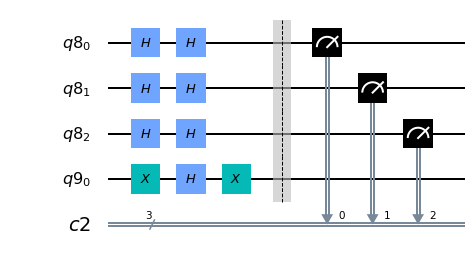

In [63]:
classical_register = ClassicalRegister(n)
dj_circuit = QuantumCircuit(input_register, output_register, classical_register)

# Apply H gates to qubits in the input register
for qubit in range(n):
    dj_circuit.h(qubit)

# Put the output qubit in |-> state
dj_circuit.x(n)
dj_circuit.h(n)

# Add oracle
dj_circuit = dj_circuit.combine(constant_oracle)

# Repeat H gates
for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.barrier()

# Measure qubits
for qubit in range(n):
    dj_circuit.measure(qubit, qubit)
    
dj_circuit.draw(output='mpl')

## Simulator

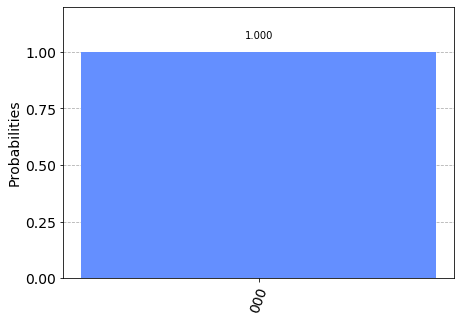

In [64]:
simulator = BasicAer.get_backend('qasm_simulator')
results = execute(dj_circuit, backend=simulator, shots=1024).result()
answer = results.get_counts()

plot_histogram(answer)

## Quantum Computer

In [65]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n+1) and not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

from qiskit.tools.monitor import job_monitor
job = execute(dj_circuit, backend=backend, shots=1024, optimization_level=3)

job_monitor(job, interval=2)

least busy backend:  ibmq_london
Job Status: job has successfully run


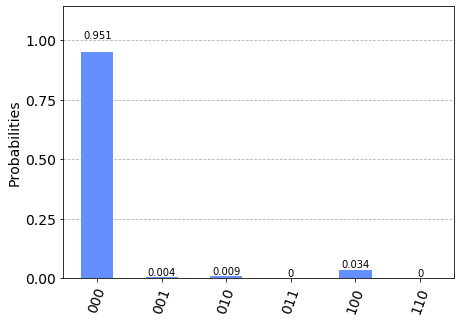

In [66]:
plot_histogram(job.result().get_counts())

## Implementing a general structure

Here the quantum circuits are defined directly without defining registers before hand. This makes it more concise at the expense of clarity. Both methods were equally well.

In [67]:
def dj_oracle(oracleType, n):
    """
    Function that creates DJ oracles and turns them into quantum gates.
    Parameters:
    oracleType - 'balanced' or 'constant'
    n - size of the input register
    """
    
    oracle_qc = QuantumCircuit(n+1)

    # Balanced oracle
    if oracleType == 'balanced':
        to_wrap = np.random.randint(2, size=n)

        for qubit in range(n):
            if to_wrap[qubit] == 1:
                oracle_qc.x(qubit)

        for qubit in range(n):
            oracle_qc.cx(qubit, n)

        for qubit in range(n):
            if to_wrap[qubit] == 1:
                oracle_qc.x(qubit)

    # Constant oracle
    else:
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)

    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle"
    return oracle_gate

def dj_algorithm(oracle, n):
    """
    Function that takes in an oracle gate and performs DJ algorithm on it.
    """
    
    dj_circuit = QuantumCircuit(n+1, n)

    # Set up the output qubit
    dj_circuit.x(n)
    dj_circuit.h(n)

    # Set up input register
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    dj_circuit.append(oracle, range(n+1))

    for qubit in range(n):
        dj_circuit.h(qubit)

    for qubit in range(n):
        dj_circuit.measure(qubit, qubit)

    return dj_circuit


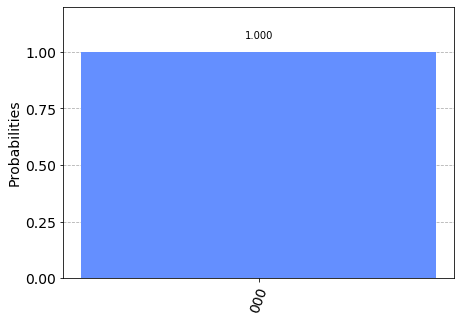

In [68]:
numQubits = 3
newOracle = dj_oracle('constant', numQubits)
newCircuit = dj_algorithm(newOracle, numQubits)

simulator = BasicAer.get_backend('qasm_simulator')
counts = execute(newCircuit, backend=simulator, shots=1).result().get_counts(newCircuit)
plot_histogram(counts)